## XGBoost Model for OSM Changeset Data

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split


### Create directories required for the code

In [11]:
import os

# Define the directory and file path for saving the model
save_dir = '../saved_parameters/changeset_model/'
model_file = os.path.join(save_dir, 'final_xgboost_model.pkl')

# Check if the directory exists, else create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory created at: {save_dir}")
else:
    print(f"Directory already exists at: {save_dir}")

Directory already exists at: ../saved_parameters/changeset_model/


### Load the data set into a data frame

In [12]:
features_df = pd.read_parquet("../data/changeset_data/osm_labelled_changeset_features_with_user_info.parquet")

#Shuffle the data entries
features_df = features_df.sample(frac=1, random_state=42).reset_index(drop=True)
features_df.head()

,changeset_id,created_at,closed_at,user,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,...,label,no_nodes,no_ways,no_relations,no_creates,no_modifications,no_deletions,uid,account_created,changes_count
0,55841613,2018-01-28 21:16:49+00:00,2018-01-28 21:16:49+00:00,clauslide,7528900,1,-33.546025,-71.606199,-33.545570,-71.605570,...,True,0,1,0,1,0,0,7528900,2018-01-26T06:58:01Z,0
1,45459256,2017-01-25 03:29:43+00:00,2017-01-25 03:29:44+00:00,Eye of the Squid,5186084,5,43.779429,-79.337066,43.780136,-79.336516,...,True,4,1,0,5,0,0,5186084,2017-01-25T02:47:25Z,0
2,31041378,2015-05-12 09:18:59+00:00,2015-05-12 09:18:59+00:00,maartinez,1738975,1,53.661516,14.608453,53.663647,14.609384,...,False,0,1,0,0,1,0,1738975,2013-09-09T09:10:27Z,0
3,58344034,2018-04-23 16:22:00+00:00,2018-04-23 16:22:00+00:00,dankpoet,4175482,5,12.129619,99.002683,12.129719,99.002799,...,False,4,1,0,5,0,0,4175482,2016-06-26T22:16:00Z,0
4,25666885,2014-09-25 14:45:21+00:00,2014-09-25 14:45:22+00:00,wsay22,1464076,1,54.778566,9.438529,54.778566,9.438529,...,True,1,0,0,0,1,0,1464076,2013-05-19T09:12:59Z,0


### Drop unnecessary columns and replace spaces with underscores

In [13]:
if features_df.columns.__contains__('geometry'):
    features_df.drop('geometry', axis=1, inplace=True)

if features_df.columns.__contains__('changeset_id'):
    features_df.drop('changeset_id', axis=1, inplace=True)

if features_df.columns.__contains__('created_at'):
    features_df.drop('created_at', axis=1, inplace=True)

if features_df.columns.__contains__('user'):
    features_df.drop('user', axis=1, inplace=True)
    
#TODO: Analyse comment and detect if suspicious. Can get a new feature like comment suspicious score.
if features_df.columns.__contains__('comment'):
    features_df.drop('comment', axis=1, inplace=True)

if features_df.columns.__contains__('uid'):
    features_df.drop('uid', axis=1, inplace=True)

if features_df.columns.__contains__('changes_count'):
    features_df.drop('changes_count', axis=1, inplace=True)

features_df.columns = features_df.columns.str.replace(' ', '_', regex=True)

features_df.head()

,closed_at,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,created_by,label,no_nodes,no_ways,no_relations,no_creates,no_modifications,no_deletions,account_created
0,2018-01-28 21:16:49+00:00,7528900,1,-33.546025,-71.606199,-33.545570,-71.605570,iD 2.6.0,True,0,1,0,1,0,0,2018-01-26T06:58:01Z
1,2017-01-25 03:29:44+00:00,5186084,5,43.779429,-79.337066,43.780136,-79.336516,iD 2.0.2,True,4,1,0,5,0,0,2017-01-25T02:47:25Z
2,2015-05-12 09:18:59+00:00,1738975,1,53.661516,14.608453,53.663647,14.609384,iD 1.7.2,False,0,1,0,0,1,0,2013-09-09T09:10:27Z
3,2018-04-23 16:22:00+00:00,4175482,5,12.129619,99.002683,12.129719,99.002799,iD 2.8.0,False,4,1,0,5,0,0,2016-06-26T22:16:00Z
4,2014-09-25 14:45:22+00:00,1464076,1,54.778566,9.438529,54.778566,9.438529,iD 1.5.4,True,1,0,0,0,1,0,2013-05-19T09:12:59Z


### One-hot Encoding

In [14]:
X = features_df.drop('label', axis=1).copy()
y = features_df['label'].copy()

X['closed_at'] = pd.to_datetime(X['closed_at']).astype(int) / 10**9
X['account_created'] = pd.to_datetime(X['account_created']).astype(int) / 10**9

X_encoded = pd.get_dummies(X, columns=['created_by'])

assert X_encoded.dtypes.__contains__('object') == False
X_encoded.head()

,closed_at,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,no_nodes,no_ways,no_relations,...,created_by_reverter;JOSM/1.5 (14945 uk),created_by_reverter_plugin/34977;JOSM/1.5 (15031 en),created_by_reverter_plugin/34999;JOSM/1.5 (15155 de),created_by_reverter_plugin/35084;JOSM/1.5 (15492 en),created_by_rocketdata.io,created_by_rosemary v0.3.12,created_by_rosemary v0.4.4,created_by_simple_revert.py,created_by_streetkeysmv,created_by_upload.py v. 1
0,1.517174e+09,7528900,1,-33.546025,-71.606199,-33.545570,-71.605570,0,1,0,...,False,False,False,False,False,False,False,False,False,False
1,1.485315e+09,5186084,5,43.779429,-79.337066,43.780136,-79.336516,4,1,0,...,False,False,False,False,False,False,False,False,False,False
2,1.431422e+09,1738975,1,53.661516,14.608453,53.663647,14.609384,0,1,0,...,False,False,False,False,False,False,False,False,False,False
3,1.524501e+09,4175482,5,12.129619,99.002683,12.129719,99.002799,4,1,0,...,False,False,False,False,False,False,False,False,False,False
4,1.411656e+09,1464076,1,54.778566,9.438529,54.778566,9.438529,1,0,0,...,False,False,False,False,False,False,False,False,False,False


### Format y and check ratio of x:y

In [15]:
y = y.replace(True, 1)
y = y.replace(False, 0)
sum(y) / len(y)

C:\Users\saise\AppData\Local\Temp\ipykernel_25568\1318066108.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(False, 0)


0.500905051834787

### Split the data between train and test set & print statistics

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

# Get the shapes of the datasets
shapes = {
    'X_train shape': X_train.shape,
    'X_test shape': X_test.shape,
    'y_train shape': y_train.shape,
    'y_test shape': y_test.shape
}

# Convert shapes to DataFrame for better display
shapes_df = pd.DataFrame(shapes, index=['Number of Samples', 'Number of Features']).T
print(shapes_df)
print()

# 1. Calculate the total number of samples in train and test sets
total_train = len(y_train)
total_test = len(y_test)

# 2. Calculate the number of vandalism (assuming 'vandalism' is labeled as 1)
vandalism_train = sum(y_train)
vandalism_test = sum(y_test)

# 3. Calculate the number of non-vandalism (assuming 'non-vandalism' is labeled as 0)
non_vandalism_train = total_train - vandalism_train
non_vandalism_test = total_test - vandalism_test

# 4. Print the statistics
print(f"Train Set Statistics:\n"
      f"Total: {total_train}\n"
      f"Vandalism: {vandalism_train}\n"
      f"Non-Vandalism: {non_vandalism_train}\n")

print(f"Test Set Statistics:\n"
      f"Total: {total_test}\n"
      f"Vandalism: {vandalism_test}\n"
      f"Non-Vandalism: {non_vandalism_test}\n")

print("sum(y_train)/len(y_train): " + str(sum(y_train) / len(y_train)))
print("sum(y_test)/len(y_test): " + str(sum(y_test) / len(y_test)))


               Number of Samples  Number of Features
X_train shape              13673                1459
X_test shape                4558                1459
y_train shape              13673               13673
y_test shape                4558                4558

Train Set Statistics:
Total: 13673
Vandalism: 6849
Non-Vandalism: 6824

Test Set Statistics:
Total: 4558
Vandalism: 2283
Non-Vandalism: 2275

sum(y_train)/len(y_train): 0.5009142104878227
sum(y_test)/len(y_test): 0.5008775778850373


### Model training with random hyperparameters and without cross validation

In [17]:
from model.xgboost_training import train_final_model, save_model
from model.hyper_parameter_search import get_random_parameters

random_parameters = get_random_parameters()

# Train Final Model with random parameters
final_base_model = train_final_model(X_train, y_train, X_test, y_test, random_parameters)

# Save the Model
save_model(final_base_model, '../saved_parameters/changeset_model/final_xgboost_base_model.pkl')


2024-10-30 02:12:44 - INFO - hyper_parameter_search.py -- Random Hyperparameters Generated: {'learning_rate': 0.01, 'max_depth': 7, 'subsample': 1.0, 'colsample_bytree': 0.8, 'lambda': 3, 'alpha': 3, 'min_child_weight': 7, 'gamma': 3, 'n_estimators': 80}

2024-10-30 02:12:50 - INFO - xgboost_training.py -- Model training complete.

2024-10-30 02:12:50 - INFO - xgboost_training.py -- Model saved to ../saved_parameters/changeset_model/final_xgboost_base_model.pkl


### Base model evaluation

Evaluating model performance on both training and test datasets...

Train Set Evaluation
Accuracy: 0.8412199224749506
AUC-ROC: 0.9137297257350275
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      6824
           1       0.85      0.82      0.84      6849

    accuracy                           0.84     13673
   macro avg       0.84      0.84      0.84     13673
weighted avg       0.84      0.84      0.84     13673


Test Set Evaluation
Accuracy: 0.8200965335673541
AUC-ROC: 0.8958678815709038
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.81      0.84      0.82      2275
           1       0.83      0.80      0.82      2283

    accuracy                           0.82      4558
   macro avg       0.82      0.82      0.82      4558
weighted avg       0.82      0.82      0.82      4558


AUC-PR Score on Test Set: 0.8983663299425964
ROC-AUC Score

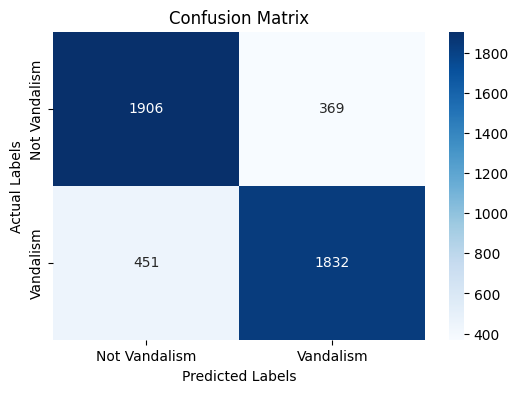

In [18]:
from evaluate_xgboost_model import (evaluate_train_test_metrics, calculate_auc_scores,
                                    plot_confusion_matrix)

# Evaluate Train and Test Metrics
y_test_pred, y_test_prob = evaluate_train_test_metrics(final_base_model, X_train, y_train, X_test, y_test)

# Calculate AUC Scores and Get Confusion Matrix
cm = calculate_auc_scores(y_test, y_test_pred, y_test_prob)

# Plot Confusion Matrix
plot_confusion_matrix(cm)

### Hyperparameter tuning with cross validation and model training with best parameters

In [19]:
from model.hyper_parameter_search import randomized_search_cv
from model.xgboost_training import train_final_model, save_model
from model.evaluate_xgboost_model import evaluate_model_with_cv

# Search and Load Hyperparameters
best_params = randomized_search_cv(X_train, y_train,  '../saved_parameters/changeset_model/best_hyperparameters.json')

# Train Final Model with best_params
final_tuned_model = train_final_model(X_train, y_train, X_test, y_test, best_params)

# (OPTIONAL): Perform Final Cross-Validation on Full Dataset
cv_scores = evaluate_model_with_cv(X_train, y_train, best_params)

# Save the Model
save_model(final_tuned_model, '../saved_parameters/changeset_model/final_xgboost_model_tuned.pkl')



2024-10-30 02:12:52 - INFO - hyper_parameter_search.py -- Hyperparameters file already exists.

2024-10-30 02:12:52 - INFO - load_hyper_parameters.py -- Loaded hyperparameters from ../saved_parameters/changeset_model/best_hyperparameters.json

2024-10-30 02:12:52 - INFO - hyper_parameter_search.py -- best hyper parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 1.0, 'alpha': 1}

2024-10-30 02:13:01 - INFO - xgboost_training.py -- Model training complete.



Performing 5-fold Cross-Validation on the entire data...



2024-10-30 02:13:25 - INFO - xgboost_training.py -- Model saved to ../saved_parameters/changeset_model/final_xgboost_model_tuned.pkl


Cross-Validation AUC Scores: [0.94708698 0.94512607 0.95148205 0.94725863 0.95449462]
Mean AUC Score: 0.949089667726499
Standard Deviation of AUC Scores: 0.0034061867502257403


### Tuned model evaluation

Evaluating model performance on both training and test datasets...

Train Set Evaluation
Accuracy: 0.9362978132085131
AUC-ROC: 0.9833178340271649
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      6824
           1       0.94      0.93      0.94      6849

    accuracy                           0.94     13673
   macro avg       0.94      0.94      0.94     13673
weighted avg       0.94      0.94      0.94     13673


Test Set Evaluation
Accuracy: 0.8828433523475209
AUC-ROC: 0.9530392340904825
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      2275
           1       0.89      0.88      0.88      2283

    accuracy                           0.88      4558
   macro avg       0.88      0.88      0.88      4558
weighted avg       0.88      0.88      0.88      4558


AUC-PR Score on Test Set: 0.9567159071618994
ROC-AUC Score

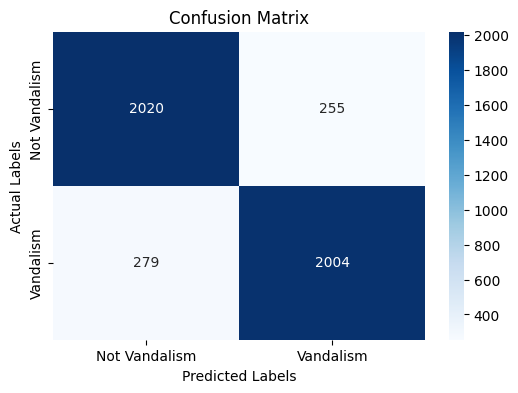

In [20]:
from evaluate_xgboost_model import (evaluate_train_test_metrics, calculate_auc_scores,
                                    plot_confusion_matrix)

# Evaluate Train and Test Metrics
y_test_pred, y_test_prob = evaluate_train_test_metrics(final_tuned_model, X_train, y_train, X_test, y_test)

# Calculate AUC Scores and Get Confusion Matrix
cm = calculate_auc_scores(y_test, y_test_pred, y_test_prob)

# Plot Confusion Matrix
plot_confusion_matrix(cm)